# Introduction

## 1. Import libraries

Import all the necessary libraries required to execute the code

In [3]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import math
import calendar


## 2. Data Import
The following code cell is used to download the dataset files from the Kaggle website. It only needs to be executed once. Additionally, you will need to generate a personal Kaggle API key in your account settings.

In [4]:
# def download_kaggle_dataset(dataset, path="data"):
#     if not os.path.exists(path):
#         os.makedirs(path)

#     api = KaggleApi()
#     api.authenticate()
#     api.dataset_download_files(dataset, path=path, unzip=True)
#     print("Dataset downloaded and extracted.")

# if __name__ == "__main__":
#     download_kaggle_dataset("arashnic/food-demand")

Based on the _['retail-demand-analysis'](https://github.com/AwanRaskall/retail-demand-analysis)_ project, **Center №13** was identified as the most active in terms of order frequency and volume. Therefore, it has been selected as the primary focus for our forecasting model since:

1. More data → More orders means more historical data for the model, which means better forecast quality.
2. Pattern stability → Stores with high activity tend to have more predictable trends.
3. Minimize outliers → Stores with high costs but low orders may have unstable purchases, which will make forecasting more difficult.

In [7]:
df = pd.read_csv('data/foodDemand_train/train.csv')
df_orders = df[df['center_id'] == 13].reset_index(drop = True)
df_orders

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1171094,1,13,1885,135.86,122.28,0,1,2132
1,1068455,1,13,1993,134.86,122.28,0,1,2418
2,1105491,1,13,2539,133.86,133.86,0,0,474
3,1486384,1,13,2139,337.62,437.53,0,0,123
4,1345938,1,13,2631,252.23,437.47,0,0,162
...,...,...,...,...,...,...,...,...,...
7041,1385493,145,13,1543,484.03,485.03,0,0,270
7042,1076678,145,13,2304,486.03,485.03,0,0,149
7043,1012260,145,13,2664,241.59,335.62,0,0,770
7044,1268089,145,13,2569,241.53,337.56,0,0,798


## 3. First acquaintance with data

In [8]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7046 non-null   int64  
 1   week                   7046 non-null   int64  
 2   center_id              7046 non-null   int64  
 3   meal_id                7046 non-null   int64  
 4   checkout_price         7046 non-null   float64
 5   base_price             7046 non-null   float64
 6   emailer_for_promotion  7046 non-null   int64  
 7   homepage_featured      7046 non-null   int64  
 8   num_orders             7046 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 495.6 KB


### 3.1. The center description

In [9]:
df_center = pd.read_csv('data/foodDemand_train/fulfilment_center_info.csv')
df_center[df_center['center_id'] == 13]

,center_id,city_code,region_code,center_type,op_area
1,13,590,56,TYPE_B,6.7


In [10]:
num_meals = df_orders['num_orders'].sum()
print(f'Total number of products ordered by center 13: {num_meals}')

Total number of products ordered by center 13: 4296545


In [11]:
df_orders['Total costs'] = df_orders.checkout_price * df_orders.num_orders
df_orders = df_orders.reset_index(drop = True)

total_costs_orders = df_orders['Total costs'].sum()
print(f'Total costs of orders for all products by center 13: {total_costs_orders}')

Total costs of orders for all products by center 13: 1127045001.1799998


Thus, the Center №13 based in city №590 and being B-type class made 7 046 orders for 4 296 545 units of products and for a total of 1 127 045 001,18 conventional monetary units over 145 weeks

### 3.2. The meal description

To create a forecasting model, we will focus on one type of product that was ordered most often or in large volumes

In [12]:
meals_num_orders = df_orders.groupby('meal_id').size().reset_index(name='num_orders')
meals_num_orders = meals_num_orders.sort_values(by = 'num_orders', ascending = False).reset_index(drop = True)

top_meal_orders = meals_num_orders.head(10)
top_meal_orders

,meal_id,num_orders
0,1062,145
1,1109,145
2,1198,145
3,1445,145
4,1311,145
5,1778,145
6,1558,145
7,1727,145
8,1754,145
9,2707,145


Since the number of orders for each product is equal, then let's calculate which product was ordered the largest number of units

In [13]:
meals_num_units = df_orders.groupby('meal_id')['num_orders'].sum().reset_index(name='num_orders')
meals_num_units = meals_num_units.sort_values(by = 'num_orders', ascending = False).reset_index(drop = True)

top_meal_units = meals_num_units.head(1)
print(f'The product with the highest number of units ordered was meal №{top_meal_units.iloc[0,0]}, amounting to {top_meal_units.iloc[0,1]} units')

The product with the highest number of units ordered was meal №1885, amounting to 334334 units


In [14]:
df_meal = pd.read_csv('data/foodDemand_train/meal_info.csv')
df_meal[df_meal['meal_id'] == 1885]

,meal_id,category,cuisine
0,1885,Beverages,Thai


To sum up, the most popular product in Center №13 was the Thai drink №1885. Given it was consistently ordered over 145 weeks with a total volume of 334 334 units across 145 separate orders, it demonstrates both long-term demand stability and high order frequency.

These characteristics make it a strong candidate for time series forecasting, as the volume and regularity of historical data provide a solid foundation for building a reliable and accurate predictive model.

## 4. Data cleaning

Due to the 'retail-demand-analysis' project we can note that:
1) There is no one column in the table that has NaN value;
2) No duplicate column/row values ​​in the table;
3) Column 'id' has only unique values.

We need:
1) Delete unnecessary columns and rows;
2) Rename columns so they express clear meaning;
3) Outliers testing.

In [10]:
# Remove unrequired rows
df_orders = df_orders.loc[df_orders['meal_id'] == 1885]
df_orders = df_orders.reset_index(drop = True)


In [11]:
# Remove unrequired columns
del df_orders['emailer_for_promotion']
del df_orders['homepage_featured']
del df_orders['center_id']
del df_orders['meal_id']

In [12]:
# Rename columns
df_orders = df_orders.rename(columns={'num_orders': 'num_units'})

Outliers in number of ordered beverages:
 49     3862
52     3794
111     879
124    3659
125    3552
131    3767
139    3631
Name: num_units, dtype: int64


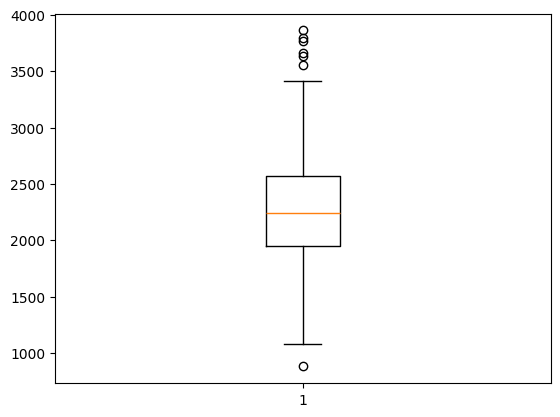

In [13]:
# IQR method emissions
Q1 = df_orders['num_units'].quantile(0.25)
Q3 = df_orders['num_units'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = df_orders[(df_orders['num_units'] < lower) | (df_orders['num_units'] > upper)]
print('Outliers in number of ordered beverages:' + '\n', outliers['num_units'])

# Graph of Outliers
plt.boxplot(df_orders['num_units'])
plt.show()

In [14]:
# Determine in which months our outliers were (1 year = 1-52 week)
def week_recogniton(week_num):
    year = (week_num - 1) // 52 + 1
    week_of_year = (week_num - 1) % 52 + 1
    month = math.ceil(week_of_year * 12 / 52)
    start_week = math.floor((month - 1) * 52 / 12) + 1
    week_in_month = week_of_year - start_week + 1
    return year, month, week_in_month

for w in outliers.index:
    year, m, wm = week_recogniton(w)
    print(f"Week {w}: {wm} week of {list(calendar.month_name[1:13])[m-1]} in the {year} year")


Week 49: 2 week of December in the 1 year
Week 52: 5 week of December in the 1 year
Week 111: 3 week of February in the 3 year
Week 124: 3 week of May in the 3 year
Week 125: 4 week of May in the 3 year
Week 131: 1 week of July in the 3 year
Week 139: 1 week of September in the 3 year


We note that the spikes in order levels do not occur on holidays (except for week 52), which means that this is not explained by increased customer demand in preparation for the holidays. We can also conclude that this is not a seasonal anomaly, since the spikes do not repeat every year.

Unfortunately, we do not have data on whether these were critical business events such as sales, promotions, or marketing campaigns.

We will save this data, since it reflects real, significant events for business.

In [15]:
# Output of final data
df_orders

,id,week,checkout_price,base_price,num_units,Total costs
0,1171094,1,135.86,122.28,2132,289653.52
1,1295835,2,135.86,121.28,1891,256911.26
2,1429724,3,133.86,122.28,2067,276688.62
3,1197234,4,134.86,122.28,2472,333373.92
4,1469105,5,143.56,120.28,1863,267452.28
...,...,...,...,...,...,...
140,1057276,141,151.38,150.38,3012,455956.56
141,1296689,142,151.38,150.38,2848,431130.24
142,1255671,143,150.41,149.38,3172,477100.52
143,1038807,144,150.38,151.38,2403,361363.14


In [16]:
df_work = pd.DataFrame({'week': df_orders.week,'num_units': df_orders.num_units})
df_work.set_index('week', inplace=True)
df_work

,num_units
week,
1,2132
2,1891
3,2067
4,2472
5,1863
...,...
141,3012
142,2848
143,3172


3. Modeling

3.1. Preparation

Creating functions for those actions that will be repeated several times

3.1.1. Graphs

In [17]:
# Plotting graphs with one or two data series
def plot_graph(*ys, title = None, figsize = (10, 4), xticks = range(0, 100, 4), labels = None):                   
    plt.figure(figsize = figsize)

    for i, y in enumerate(ys):
        label = labels[i] if labels and i < len(labels) else f'Dataset {i+1}'
        plt.plot(y, label = label)                

    if title:
        plt.title(title, fontsize = 14)
    plt.xlabel('Week', fontsize = 12)
    plt.ylabel('Amount of units', fontsize = 12)
    
    plt.xticks(xticks)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
# Plotting autocorrelation and partial autocorrelation graphs
def autoreg(data, lag = 62):         
    plot_acf(data, lags = lag)       
    plot_pacf(data, lags = lag)
    plt.tight_layout()
    plt.show()

3.1.2. Tests

In [19]:
# KPSS test
def test_by_KPSS(data, regression = 'c'):                 
    kpsstest = kpss(data, regression = regression)                  
    print ('Results of KPSS Test: %f' % kpsstest[0])
    print('p-value: %f' % kpsstest[1])
    print('Critical Values:')
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        print('\t%s: %.3f' % (key, value))

In [20]:
# Augmented Dickey–Fuller test (ADF)
def test_by_AdFuller(data, regression = 'c'):                            
    result = adfuller(data, regression = regression)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

3.2. Analysis of first data

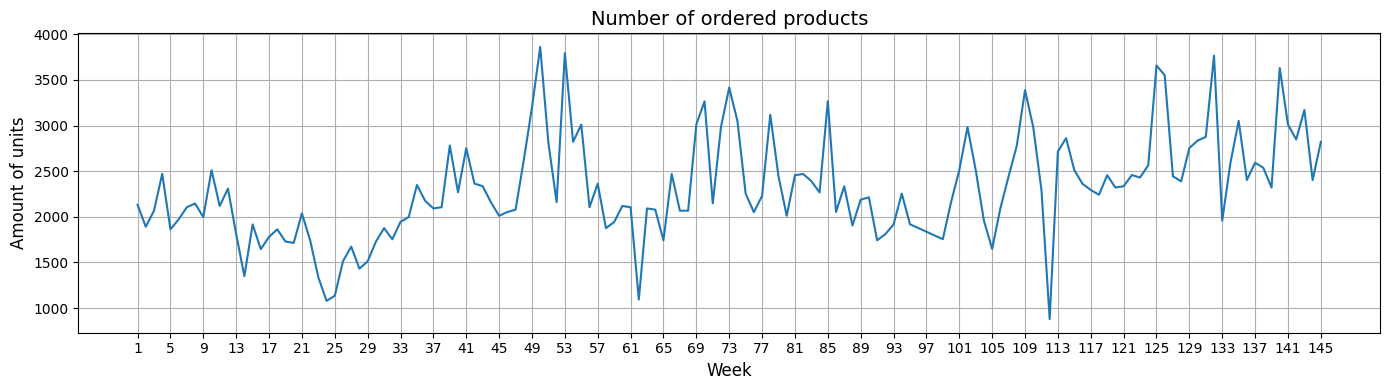

In [21]:
plot_graph(df_work, title = 'Number of ordered products', figsize = (14, 4), xticks = range(min(df_orders.week), max(df_orders.week) + 1, 4))

In [22]:
# STL decompositon with perios equled 52 weeks (~ 1 year)
stl = STL(df_work, period = 52)
stl_fit = stl.fit()

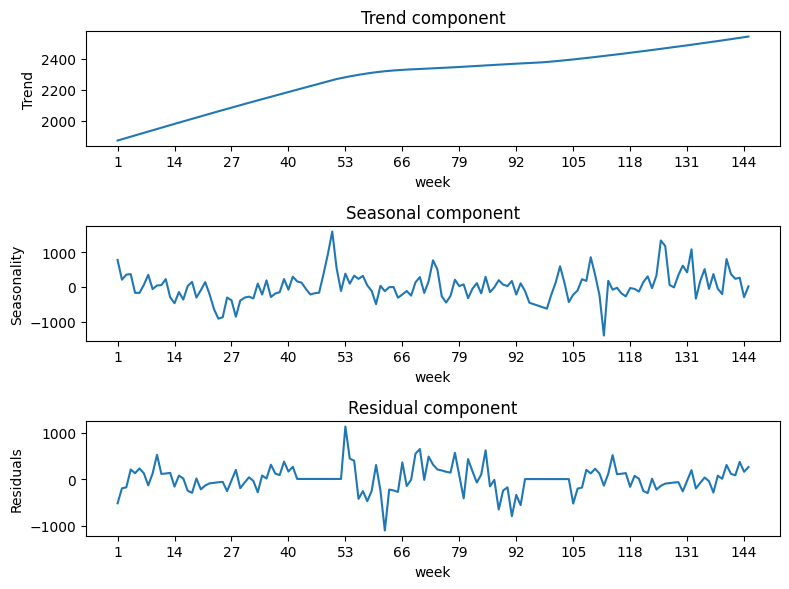

In [23]:
plt.figure(figsize = (8, 6))

# Trend
plt.subplot(311)
stl_fit.trend.plot()
plt.title('Trend component')
plt.ylabel('Trend')
plt.xticks(range(1,146, 13))
plt.tight_layout()

# Seasonality
plt.subplot(312)
stl_fit.seasonal.plot()
plt.title('Seasonal component')
plt.ylabel('Seasonality')
plt.xticks(range(1,146, 13))
plt.tight_layout()

# 3.3 Residual - not explained by trend and seasonality
plt.subplot(313)
stl_fit.resid.plot()
plt.title('Residual component')
plt.ylabel('Residuals')
plt.xticks(range(1,146, 13))
plt.tight_layout()

plt.show()

After decomposition we can draw the following conclusions:
1) The time series graph clearly shows a steady upward trend: orders volume gradually increases over time;
2) A regular seasonal component with a period of 52 weeks (annual seasonality) was identified. The amplitude of seasonal fluctuations reaches about 3 000 units: this indicates that in some periods of the year, orders are consistently higher;

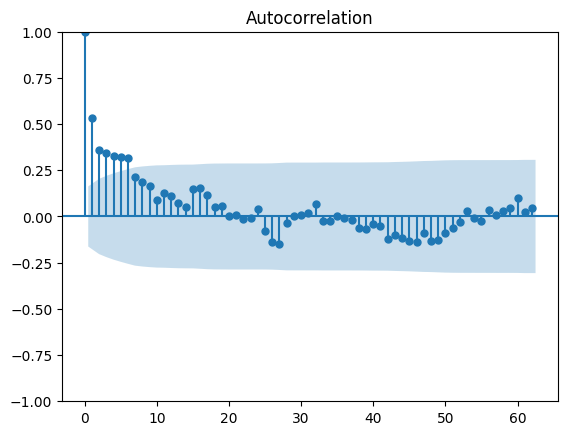

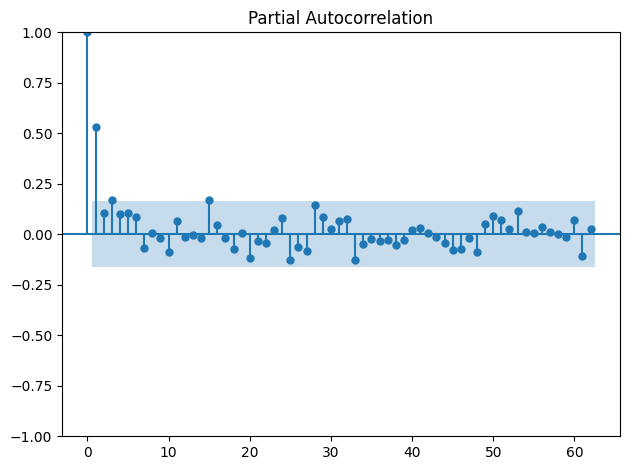

In [24]:
# Autocorrelation and partial autocorrelation
autoreg(df_work)

In [25]:
# Check for stationarity
test_by_KPSS(df_work)
print('')
test_by_AdFuller(df_work)

Results of KPSS Test: 0.745295
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ADF Statistic: -3.868856
p-value: 0.002276
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


C:\Users\user\AppData\Local\Temp\ipykernel_18716\3308023662.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(data, regression = regression)
